In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow и tf.keras
import tensorflow as tf
import torch
from tensorflow import keras
#import keras
# Вспомогательные библиотеки
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2

from keras.models import Model
from keras.layers import Input, Dense, Concatenate, Flatten, BatchNormalization
from keras.layers import Dense, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D, Activation

print(tf.__version__)

1.15.0


Using TensorFlow backend.


In [3]:
!unzip train_line_spacing.zip #images

Archive:  train_line_spacing.zip
  inflating: train_line_spacing/1.jpg  
  inflating: train_line_spacing/10.jpg  
  inflating: train_line_spacing/100.jpg  
  inflating: train_line_spacing/101.jpg  
  inflating: train_line_spacing/102.jpg  
  inflating: train_line_spacing/103.jpg  
  inflating: train_line_spacing/104.jpg  
  inflating: train_line_spacing/105.jpg  
  inflating: train_line_spacing/106.jpg  
  inflating: train_line_spacing/107.jpg  
  inflating: train_line_spacing/108.jpg  
  inflating: train_line_spacing/109.jpg  
  inflating: train_line_spacing/11.jpg  
  inflating: train_line_spacing/110.jpg  
  inflating: train_line_spacing/111.jpg  
  inflating: train_line_spacing/112.jpg  
  inflating: train_line_spacing/113.jpg  
  inflating: train_line_spacing/114.jpg  
  inflating: train_line_spacing/115.jpg  
  inflating: train_line_spacing/116.jpg  
  inflating: train_line_spacing/117.jpg  
  inflating: train_line_spacing/118.jpg  
  inflating: train_line_spacing/119.jpg  
  inf

In [0]:
train = pd.read_csv('train_line_spacing.csv')

In [5]:
train.head()

,img,distance
0,1.jpg,1
1,2.jpg,1
2,3.jpg,1
3,4.jpg,0
4,5.jpg,0


In [6]:
train.shape

(832, 2)

In [7]:
train[train.distance == 0].shape, train[train.distance == 1].shape, train[train.distance == 2].shape #кол-во классов

((266, 2), (290, 2), (276, 2))

In [8]:
!unzip test_line_spacing.zip #images

Archive:  test_line_spacing.zip
  inflating: test_line_spacing/100.jpg  
  inflating: test_line_spacing/101.jpg  
  inflating: test_line_spacing/102.jpg  
  inflating: test_line_spacing/103.jpg  
  inflating: test_line_spacing/104.jpg  
  inflating: test_line_spacing/105.jpg  
  inflating: test_line_spacing/106.jpg  
  inflating: test_line_spacing/107.jpg  
  inflating: test_line_spacing/108.jpg  
  inflating: test_line_spacing/109.jpg  
  inflating: test_line_spacing/110.jpg  
  inflating: test_line_spacing/111.jpg  
  inflating: test_line_spacing/112.jpg  
  inflating: test_line_spacing/113.jpg  
  inflating: test_line_spacing/114.jpg  
  inflating: test_line_spacing/115.jpg  
  inflating: test_line_spacing/116.jpg  
  inflating: test_line_spacing/117.jpg  
  inflating: test_line_spacing/118.jpg  
  inflating: test_line_spacing/119.jpg  
  inflating: test_line_spacing/120.jpg  
  inflating: test_line_spacing/121.jpg  
  inflating: test_line_spacing/122.jpg  
  inflating: test_line_sp

In [0]:
test = pd.read_csv('test_line_spacing.csv')

In [10]:
test.head()

,img,distance
0,100.jpg,1
1,101.jpg,1
2,102.jpg,1
3,103.jpg,2
4,104.jpg,2


In [11]:
test.shape

(221, 2)

In [12]:
test[test.distance == 0].shape, test[test.distance == 1].shape, test[test.distance == 2].shape #кол-во классов

((73, 2), (78, 2), (70, 2))

In [0]:
hei = 128
wei = 64

**Добавление данных в x_test, y_test**

In [14]:
x_test = []
y_test = []

for i in range (test.shape[0]):
    x,y = test.values[i]
    x = cv2.imread('test_line_spacing/{}'.format(x))
    #x = strong_aug(p=0.2)
    x = cv2.resize(x, (hei, wei))
    x_test += [x]
    y_test += [y]
    
x_test = np.array(x_test) / 255.
y_test = np.array(y_test)

x_test.shape

(221, 64, 128, 3)

**Генератор батчей для train**

In [0]:
#Объявим генератор
def keras_generator(gen_df, batch_size):#генератор картинок в батч (создание батча)
    while True:
        x_train = []
        y_train = []
        

        for i in range (batch_size):

            x,y = train.sample(1).values[0]
            #print(x)
            x = cv2.imread('train_line_spacing/{}'.format(x))
            #x = strong_aug(p=0.2)
            x = cv2.resize(x, (hei, wei))
            x_train += [x]
            y_train += [y]

        #y_train = keras.utils.to_categorical(y_train,10)
        x_train = np.array(x_train) / 255.
        y_train = np.array(y_train)

        yield x_train, y_train

**Архитектура сети**

In [0]:
inp = Input(shape=(wei, hei, 3))

conv_1_1 = Conv2D(32, (3, 3), padding='same')(inp)
conv_1_1 = Activation('relu')(conv_1_1)

conv_1_2 = Conv2D(32, (3, 3), padding='same')(conv_1_1)
conv_1_2 = Activation('relu')(conv_1_2)

pool_1 = MaxPooling2D(2)(conv_1_2)
pool_1 = Dropout(0.2)(pool_1)
pool_1 = BatchNormalization()(pool_1)

conv_2_1 = Conv2D(64, (3, 3), padding='same')(pool_1)
conv_2_1 = Activation('relu')(conv_2_1)

conv_2_2 = Conv2D(64, (3, 3), padding='same')(conv_2_1)
conv_2_2 = Activation('relu')(conv_2_2)

pool_2 = MaxPooling2D(2)(conv_2_2)
pool_2 = Dropout(0.2)(pool_2)
pool_2 = BatchNormalization()(pool_2)


conv_3_1 = Conv2D(128, (3, 3), padding='same')(pool_2)
conv_3_1 = Activation('relu')(conv_3_1)

conv_3_2 = Conv2D(128, (3, 3), padding='same')(conv_3_1)
conv_3_2 = Activation('relu')(conv_3_2) #conv_3_2.shape = (64,64,128)

pool_3 = MaxPooling2D(2)(conv_3_2) #pool_3.shape = (32,32,128)
pool_3 = Dropout(0.2)(pool_3)
pool_3 = BatchNormalization()(pool_3)


conv_4_1 = Conv2D(256, (3, 3), padding='same')(pool_3)
conv_4_1 = Activation('relu')(conv_4_1)

conv_4_2 = Conv2D(256, (3, 3), padding='same')(conv_4_1)
conv_4_2 = Activation('relu')(conv_4_2) #conv_4_2.shape = (32,32,256)

pool_4 = MaxPooling2D(2)(conv_4_2) #pool_4.shape = (16,16,256)
pool_4 = Dropout(0.2)(pool_4)
pool_4 = BatchNormalization()(pool_4)



flat = Flatten()(pool_4)
layer1 = Dense(128, activation='relu')(flat)
layer1 = Dropout(0.2)(layer1)
layer1 = BatchNormalization()(layer1)

layer2 = Dense(256, activation='relu')(layer1)
layer2 = Dropout(0.2)(layer2)
layer2 = BatchNormalization()(layer2)

layer3 = Dense(512, activation='relu')(layer2)
layer3 = Dropout(0.2)(layer3)
layer3 = BatchNormalization()(layer3)

layer4 = Dense(64, activation='relu')(layer3)
layer4 = Dropout(0.2)(layer4)
layer4 = BatchNormalization()(layer4)

layer_out = Dense(3, activation='softmax')(layer4)

model = Model(inputs=inp, outputs=layer_out)

In [0]:
#model.summary()

In [0]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

**Обучение через генератор, т.е. с батчами**

In [0]:
batch_size = 32
model.fit_generator(keras_generator(train, batch_size),
              steps_per_epoch=100,#каждую эпоху - 100 батчей
              epochs=20,
              verbose=1,#будем выводить результат
              shuffle=True)

Epoch 1/20
100/100 [==============================] - 11s 107ms/step - loss: 0.9029 - acc: 0.6050
Epoch 2/20
100/100 [==============================] - 9s 88ms/step - loss: 0.5429 - acc: 0.7750
Epoch 3/20
100/100 [==============================] - 9s 88ms/step - loss: 0.4293 - acc: 0.8231
Epoch 4/20
100/100 [==============================] - 9s 88ms/step - loss: 0.4215 - acc: 0.8272
Epoch 5/20
100/100 [==============================] - 9s 88ms/step - loss: 0.3361 - acc: 0.8709
Epoch 6/20
100/100 [==============================] - 9s 87ms/step - loss: 0.2703 - acc: 0.8894
Epoch 7/20
100/100 [==============================] - 9s 88ms/step - loss: 0.2439 - acc: 0.9081
Epoch 8/20
100/100 [==============================] - 9s 88ms/step - loss: 0.2348 - acc: 0.9084
Epoch 9/20
100/100 [==============================] - 9s 88ms/step - loss: 0.1465 - acc: 0.9441
Epoch 10/20
100/100 [==============================] - 9s 88ms/step - loss: 0.1335 - acc: 0.9494
Epoch 11/20
100/100 [================

In [0]:
for x_train,y_train in keras_generator(train,train.shape[0]):
    break

In [17]:
x_train.shape

(832, 64, 128, 3)

In [18]:
train_loss, train_acc = model.evaluate(x_train, y_train)

print('\nТочность на обучающих данных:', train_acc)
print('\nОшибка на обучающих данных:', train_loss)

832/832 [==============================] - 7s 9ms/sample - loss: 0.1142 - acc: 0.9567

Точность на обучающих данных: 0.9567308

Ошибка на обучающих данных: 0.11420205081454836


In [19]:
test_loss, test_acc = model.evaluate(x_test, y_test)

print('\nТочность на проверочных данных:', test_acc)
print('\nОшибка на проверочных данных:', test_loss)

221/221 [==============================] - 0s 2ms/sample - loss: 1.4456 - acc: 0.7059

Точность на проверочных данных: 0.7058824

Ошибка на проверочных данных: 1.4456462973383217


In [2]:
#model.save('neural_network_line_spacing.h5') #сохранение нейросети в файл

from tensorflow.keras.models import load_model
model = load_model('!!!71%!!!   neural_network_line_spacing.h5') #загрузка нейросети из файла

#pred = model.predict(x_test) #предсказание

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [0]:
pred = model.predict(x_test)

In [21]:
pred.shape

(221, 3)

In [22]:
np.argmax(pred[15]),y_test[15]

(2, 2)

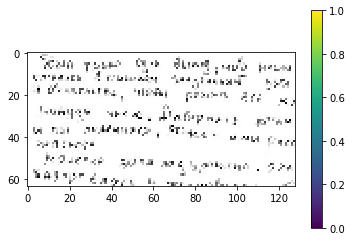

In [23]:
plt.figure()
plt.imshow(x_test[15])
plt.colorbar()
plt.grid(False)
plt.show()

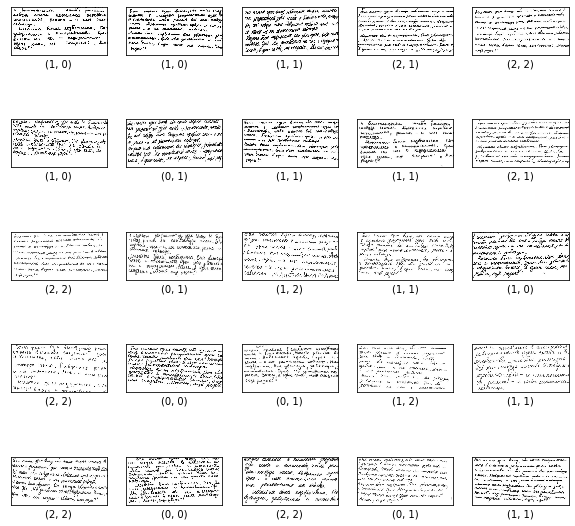

In [24]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_test[i], cmap=plt.cm.binary)
    plt.xlabel((y_test[i],np.argmax(pred[i])))
plt.show()

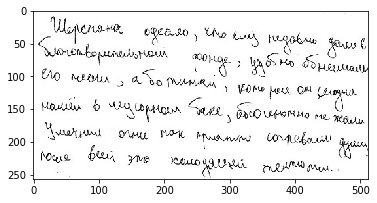

In [29]:
way='142.jpg'
#img = Image.open(way)
img = cv2.imread(way)
plt.imshow(img)
img = cv2.resize(img, (hei, wei)) / 255.

In [0]:
'''def binarize_array(numpy_array):
    """Binarize a numpy array."""
    for i in range(len(numpy_array)):
        for j in range(len(numpy_array[0])):
            if (numpy_array[i][j][0] > 150 and numpy_array[i][j][1] > 150 and numpy_array[i][j][2] > 150
                or numpy_array[i][j][0] > 180 or numpy_array[i][j][1] > 180 or numpy_array[i][j][2] > 180):
                numpy_array[i][j] = 255
            else:
                numpy_array[i][j] = 0
    return numpy_array
img = binarize_array(img)
img = cv2.resize(img, (hei, wei))
plt.imshow(img)'''

In [0]:
pred_img = model.predict(img.reshape(1,wei,hei,3))

In [31]:
print('Pred_img: ',np.argmax(pred_img))

Pred_img:  2
